In [1]:
import math

# -------------------------
# 已知参数 (单位：µm)
# -------------------------
D0 = 20.0    # 初始锡滴直径
D_top = 40.0  # 圆台上直径
D_bot = 350.0 # 圆台下直径

# -------------------------
# 1. 球体体积
# -------------------------
V_sphere = math.pi / 6 * D0**3

# -------------------------
# 2. 圆台体积公式
# -------------------------
def frustum_volume(h, D1, D2):
    return math.pi * h / 12.0 * (D1**2 + D1*D2 + D2**2)

# 解析解（令体积相等，解 h）
h_closed = 2 * D0**3 / (D_top**2 + D_top*D_bot + D_bot**2)

# -------------------------
# 3. 数值积分计算
# -------------------------
def frustum_volume_by_sum(h, dh):
    """
    用中点法数值积分计算圆台体积
    h : 厚度 (µm)
    dh: 步长 (µm)
    """
    R_top = D_top / 2.0
    R_bot = D_bot / 2.0
    n_steps = max(1, int(math.ceil(h / dh)))
    dz = h / n_steps
    vol = 0.0
    for i in range(n_steps):
        z = (i + 0.5) * dz
        r = R_top + (R_bot - R_top) * (z / h)  # 半径线性插值
        vol += math.pi * r * r * dz
    return vol

def find_h_by_bisection(dh, tol=1e-9, h_min=1e-6, h_max=10.0):
    """
    用二分法找出使得数值积分体积 ≈ 球体体积的厚度 h
    """
    while frustum_volume_by_sum(h_max, dh) < V_sphere:
        h_max *= 2.0
        if h_max > 1e6:
            raise RuntimeError("搜索范围过大")
    lo, hi = h_min, h_max
    for _ in range(100):
        mid = 0.5 * (lo + hi)
        vmid = frustum_volume_by_sum(mid, dh)
        if abs(vmid - V_sphere) / V_sphere < tol:
            return mid
        if vmid > V_sphere:
            hi = mid
        else:
            lo = mid
    return 0.5 * (lo + hi)

# -------------------------
# 4. 运行并输出结果
# -------------------------
print("球体体积 V_sphere = {:.6f} µm³".format(V_sphere))
print("解析解厚度 h = {:.12f} µm = {:.6f} nm".format(h_closed, h_closed*1000))

step_sizes = [1e-1, 1e-2, 1e-3, 5e-4, 1e-4]  # µm
print("\n数值积分结果 (中点法 + 二分法)：")
for dh in step_sizes:
    h_num = find_h_by_bisection(dh)
    print("  dh = {:6.1e} µm -> h = {:.12f} µm = {:.6f} nm".format(dh, h_num, h_num*1000))

# 验证体积相等性
V_check = frustum_volume(h_closed, D_top, D_bot)
print("\n解析解体积与球体体积差值 = {:.3e}".format(V_check - V_sphere))


球体体积 V_sphere = 4188.790205 µm³
解析解厚度 h = 0.115858073860 µm = 115.858074 nm

数值积分结果 (中点法 + 二分法)：
  dh = 1.0e-01 µm -> h = 0.121126094122 µm = 121.126094 nm
  dh = 1.0e-02 µm -> h = 0.115998212748 µm = 115.998213 nm
  dh = 1.0e-03 µm -> h = 0.115859571718 µm = 115.859572 nm
  dh = 5.0e-04 µm -> h = 0.115858448310 µm = 115.858448 nm
  dh = 1.0e-04 µm -> h = 0.115858088878 µm = 115.858089 nm

解析解体积与球体体积差值 = 0.000e+00


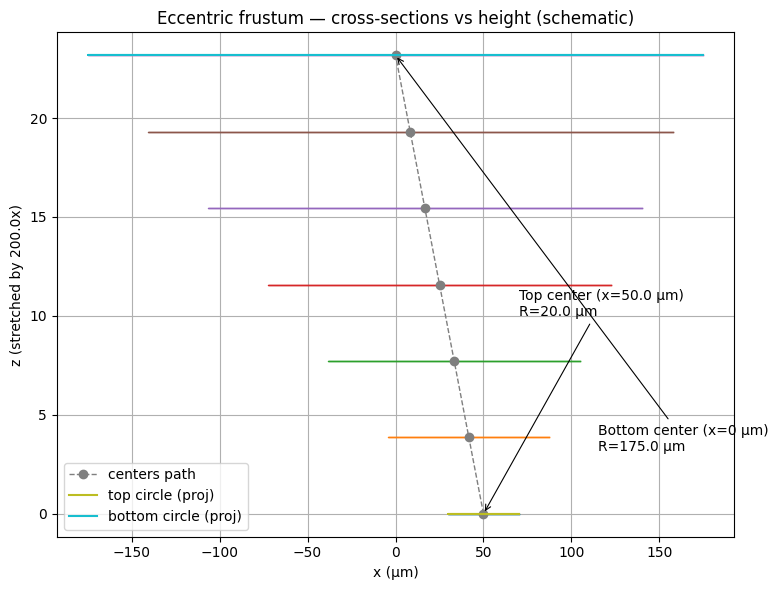

In [2]:
# Retry: plot eccentric frustum cross-sections (x-z schematic).
import math
import numpy as np
import matplotlib.pyplot as plt

# Geometry (µm)
D_top = 40.0
D_bot = 350.0
h = 0.11585807385952208

offset_x = 50.0  # µm offset for visualization
n_slices = 7
R_top = D_top / 2.0
R_bot = D_bot / 2.0

zs = np.linspace(0, h, n_slices)
centers_x = np.linspace(offset_x, 0.0, n_slices)
radii = R_top + (R_bot - R_top) * (zs / h)
theta = np.linspace(0, 2*np.pi, 360)

z_scale = 200.0

fig, ax = plt.subplots(figsize=(8,6))

for i, z in enumerate(zs):
    x_center = centers_x[i]
    r = radii[i]
    x_circle = x_center + r * np.cos(theta)
    ax.plot(x_circle, np.full_like(x_circle, z * z_scale), linewidth=1)

ax.plot(centers_x, zs * z_scale, marker='o', linestyle='--', linewidth=1, label='centers path')

x_top = offset_x + R_top * np.cos(theta)
ax.plot(x_top, np.full_like(x_top, zs[0]*z_scale), linewidth=1.5, label='top circle (proj)')
x_bot = 0.0 + R_bot * np.cos(theta)
ax.plot(x_bot, np.full_like(x_bot, zs[-1]*z_scale), linewidth=1.5, label='bottom circle (proj)')

ax.annotate(f"Top center (x={offset_x:.1f} µm)\nR={R_top:.1f} µm", xy=(offset_x, zs[0]*z_scale), xytext=(offset_x+20, zs[0]*z_scale+10),
            arrowprops=dict(arrowstyle="->", linewidth=0.8))
ax.annotate(f"Bottom center (x=0 µm)\nR={R_bot:.1f} µm", xy=(0.0, zs[-1]*z_scale), xytext=(R_bot-60, zs[-1]*z_scale-20),
            arrowprops=dict(arrowstyle="->", linewidth=0.8))

ax.set_xlabel("x (µm)")
ax.set_ylabel(f"z (stretched by {z_scale}x)")
ax.set_title("Eccentric frustum — cross-sections vs height (schematic)")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/rot_sym_example.png'

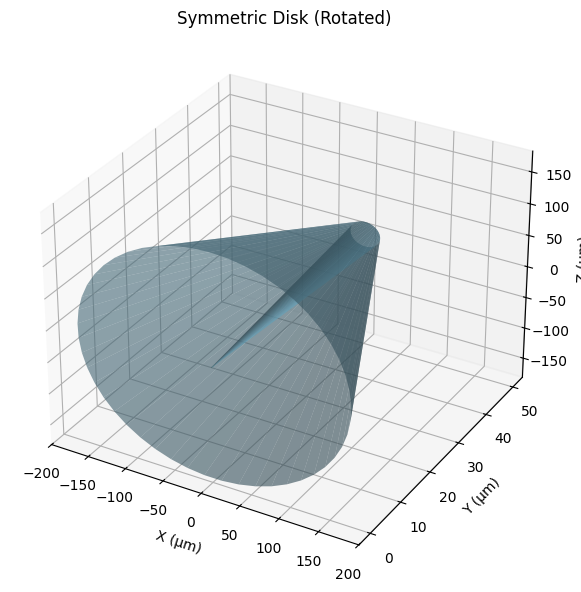

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 修复后的旋转示意图绘制函数
def plot_rotational_schematic(xs, ys, title, filename):
    """
    绘制旋转后的示意图：将给定的剖面 (xs, ys) 绕 y 轴旋转生成的三维形状投影。
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    # 创建旋转
    theta = np.linspace(0, 2*np.pi, 50)
    Xs, Thetas = np.meshgrid(xs, theta)
    Ys = np.tile(ys, (50,1))
    Zs = Xs * np.cos(Thetas)
    Xproj = Xs * np.sin(Thetas)

    ax.plot_surface(Xproj, Ys, Zs, color="skyblue", alpha=0.6, rstride=1, cstride=1, linewidth=0)

    ax.set_xlabel("X (µm)")
    ax.set_ylabel("Y (µm)")
    ax.set_zlabel("Z (µm)")
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

# 定义两个示例剖面
# 对称示例：小端(20 µm)到大端(350 µm)
xs_sym = np.array([0, 20, 175])
ys_sym = np.array([0, 50, 0])  # 假设高度50微米

# 非对称示例：小端仍然40 µm直径，但侧壁偏心
xs_asym = np.array([0, 20, 40, 200, 350])
ys_asym = np.array([0, 50, 55, 30, 0])

# 绘制示意图
plot_rotational_schematic(xs_sym, ys_sym, "Symmetric Disk (Rotated)", "/mnt/data/rot_sym_example.png")
plot_rotational_schematic(xs_asym, ys_asym, "Asymmetric Disk (Rotated)", "/mnt/data/rot_asym_example.png")

"/mnt/data/rot_sym_example.png", "/mnt/data/rot_asym_example.png"


方法1: 使用NumPy的polyfit进行线性拟合
斜率: 2.2962
截距: 1.8428

方法2: 使用SciPy的linregress进行线性拟合
斜率: 2.2962
截距: 1.8428
R值(相关系数): 0.9718
R平方: 0.9445
P值: 0.0000
标准误差: 0.1052

方法3: 使用Scikit-learn进行线性拟合
斜率: 2.2962
截距: 1.8428
R平方: 0.9445


C:\Users\Michael\AppData\Local\Temp\ipykernel_15068\1033550427.py:81: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
f:\JupyterNotebook\Feather\.v\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


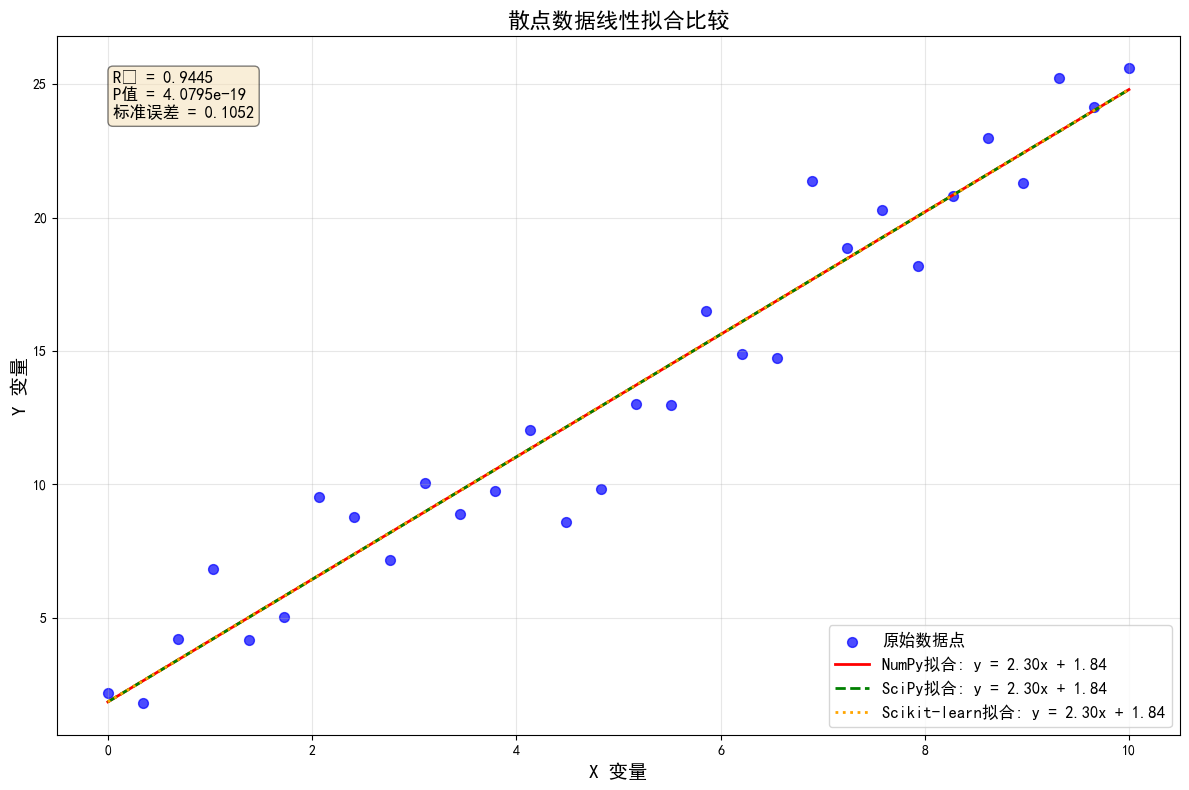

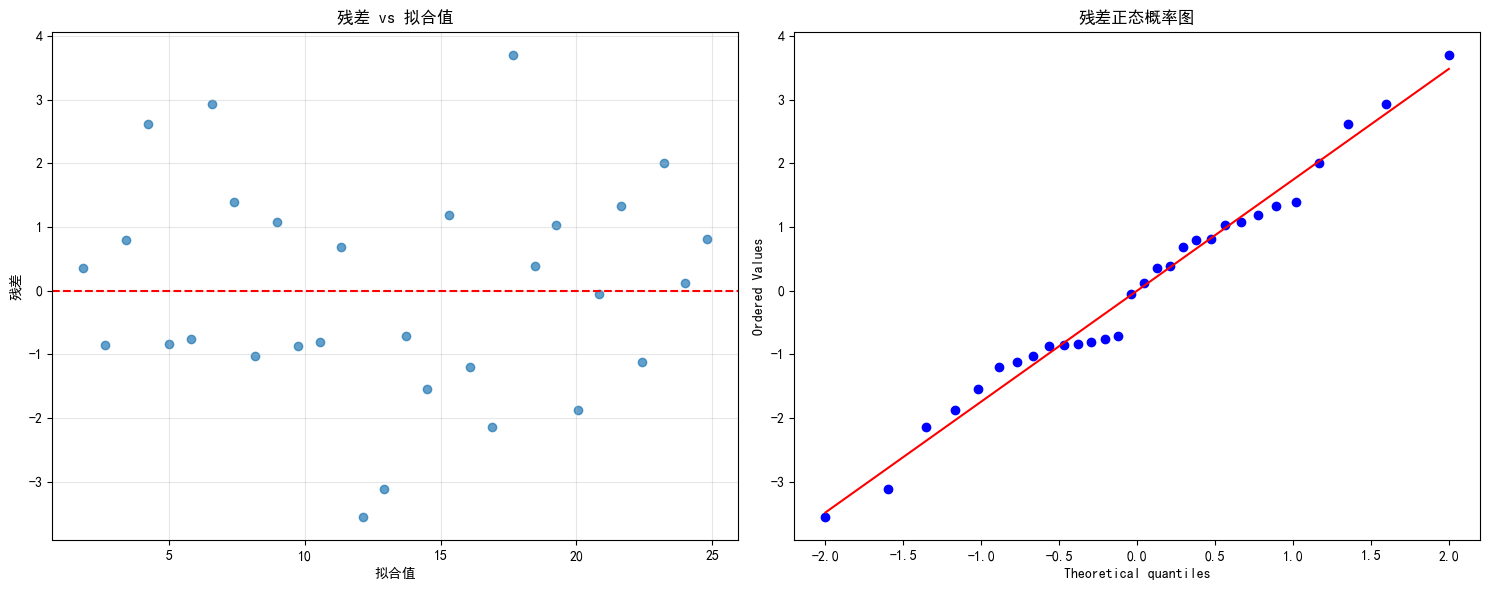


预测新数据点:
x = 2.5, 预测 y = 7.58
x = 5.0, 预测 y = 13.32
x = 7.5, 预测 y = 19.06
x = 10.5, 预测 y = 25.95

计算置信区间:
x = 2.5: 预测值 = 7.58, 95%置信区间 = [7.53, 7.63]
x = 5.0: 预测值 = 13.32, 95%置信区间 = [13.28, 13.36]
x = 7.5: 预测值 = 19.06, 95%置信区间 = [19.01, 19.12]
x = 10.5: 预测值 = 25.95, 95%置信区间 = [25.87, 26.04]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# 生成示例数据
np.random.seed(42)  # 设置随机种子以确保结果可重现
x = np.linspace(0, 10, 30)
y = 2.5 * x + 1.2 + np.random.normal(0, 2, 30)  # 添加一些随机噪声

# 方法1: 使用NumPy的polyfit进行线性拟合
print("方法1: 使用NumPy的polyfit进行线性拟合")
coefficients = np.polyfit(x, y, 1)  # 1表示线性拟合
slope_np = coefficients[0]
intercept_np = coefficients[1]
print(f"斜率: {slope_np:.4f}")
print(f"截距: {intercept_np:.4f}")

# 创建拟合线
poly_func = np.poly1d(coefficients)
y_fit_np = poly_func(x)

# 方法2: 使用SciPy的linregress进行线性拟合
print("\n方法2: 使用SciPy的linregress进行线性拟合")
slope_scipy, intercept_scipy, r_value, p_value, std_err = stats.linregress(x, y)
print(f"斜率: {slope_scipy:.4f}")
print(f"截距: {intercept_scipy:.4f}")
print(f"R值(相关系数): {r_value:.4f}")
print(f"R平方: {r_value**2:.4f}")
print(f"P值: {p_value:.4f}")
print(f"标准误差: {std_err:.4f}")

# 创建拟合线
y_fit_scipy = slope_scipy * x + intercept_scipy

# 方法3: 使用Scikit-learn进行线性拟合
print("\n方法3: 使用Scikit-learn进行线性拟合")
# 将x转换为二维数组（sklearn要求特征矩阵是二维的）
x_reshaped = x.reshape(-1, 1)
model = LinearRegression()
model.fit(x_reshaped, y)
slope_sklearn = model.coef_[0]
intercept_sklearn = model.intercept_
print(f"斜率: {slope_sklearn:.4f}")
print(f"截距: {intercept_sklearn:.4f}")
print(f"R平方: {model.score(x_reshaped, y):.4f}")

# 创建拟合线
y_fit_sklearn = model.predict(x_reshaped)

# 可视化结果
plt.figure(figsize=(12, 8))

# 绘制原始数据点
plt.scatter(x, y, color='blue', alpha=0.7, label='原始数据点', s=50)

# 绘制三种方法的拟合线
plt.plot(x, y_fit_np, color='red', linewidth=2, label=f'NumPy拟合: y = {slope_np:.2f}x + {intercept_np:.2f}')
plt.plot(x, y_fit_scipy, color='green', linestyle='--', linewidth=2, 
         label=f'SciPy拟合: y = {slope_scipy:.2f}x + {intercept_scipy:.2f}')
plt.plot(x, y_fit_sklearn, color='orange', linestyle=':', linewidth=2, 
         label=f'Scikit-learn拟合: y = {slope_sklearn:.2f}x + {intercept_sklearn:.2f}')

# 添加图例、标题和标签
plt.legend(fontsize=12)
plt.title('散点数据线性拟合比较', fontsize=16)
plt.xlabel('X 变量', fontsize=14)
plt.ylabel('Y 变量', fontsize=14)
plt.grid(True, alpha=0.3)

# 添加拟合统计信息
textstr = f'R² = {r_value**2:.4f}\nP值 = {p_value:.4e}\n标准误差 = {std_err:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# 残差分析
residuals = y - y_fit_scipy

# 创建残差图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 残差与拟合值的关系
ax1.scatter(y_fit_scipy, residuals, alpha=0.7)
ax1.axhline(y=0, color='red', linestyle='--')
ax1.set_xlabel('拟合值')
ax1.set_ylabel('残差')
ax1.set_title('残差 vs 拟合值')
ax1.grid(True, alpha=0.3)

# 残差的正态概率图
stats.probplot(residuals, dist="norm", plot=ax2)
ax2.set_title('残差正态概率图')

plt.tight_layout()
plt.show()

# 预测新数据点
print("\n预测新数据点:")
new_x = np.array([2.5, 5.0, 7.5, 10.5])
new_x_reshaped = new_x.reshape(-1, 1)
predictions = model.predict(new_x_reshaped)

for i, (x_val, y_val) in enumerate(zip(new_x, predictions)):
    print(f"x = {x_val:.1f}, 预测 y = {y_val:.2f}")

# 计算置信区间
print("\n计算置信区间:")
# 使用SciPy的方法计算置信区间
# 首先计算预测标准误差
n = len(x)
x_mean = np.mean(x)
t_value = stats.t.ppf(0.975, n-2)  # 95%置信区间，t分布临界值

# 对于每个新点计算置信区间
for i, x_val in enumerate(new_x):
    y_pred = slope_scipy * x_val + intercept_scipy
    se = std_err * np.sqrt(1/n + (x_val - x_mean)**2 / np.sum((x - x_mean)**2))
    ci_lower = y_pred - t_value * se
    ci_upper = y_pred + t_value * se
    print(f"x = {x_val:.1f}: 预测值 = {y_pred:.2f}, 95%置信区间 = [{ci_lower:.2f}, {ci_upper:.2f}]")\
        